# Nixtla Python Packages for Forecasting

## MLForecast

### MLForecast Intro

MLForecast does feature engineering and takes care of the updates for you, the user only has to provide a regressor that follows the scikit-learn API (implements fit and predict) and specify the features that she wants to use. These features can be lags, lag-based transformations, and date features.

For many years clasical methods like ARIMA or ETS dominated the forecasting field. One of the reasons was that most of the use cases involved forecasting low-frequency serises with monthly, quarterly, or yearly granuarity. Futhermore, there weren't many time-series datasets, so fitting a single model to each one and getting forecasts from them was straightforward. However, in recent years, the need to forecast bigger datasets higher frequencies has risen. To address this problem, there have been efforts in proposing different methods that can train a single model on many time series. Some deep learning architectures are ESRNN, DeepAR, NBeats, NHits. **Also traditional machine learning models like gradient boosting trees have been used as well, and have shown that they can achieve very good performance as well.**

<AxesSubplot: xlabel='ds'>

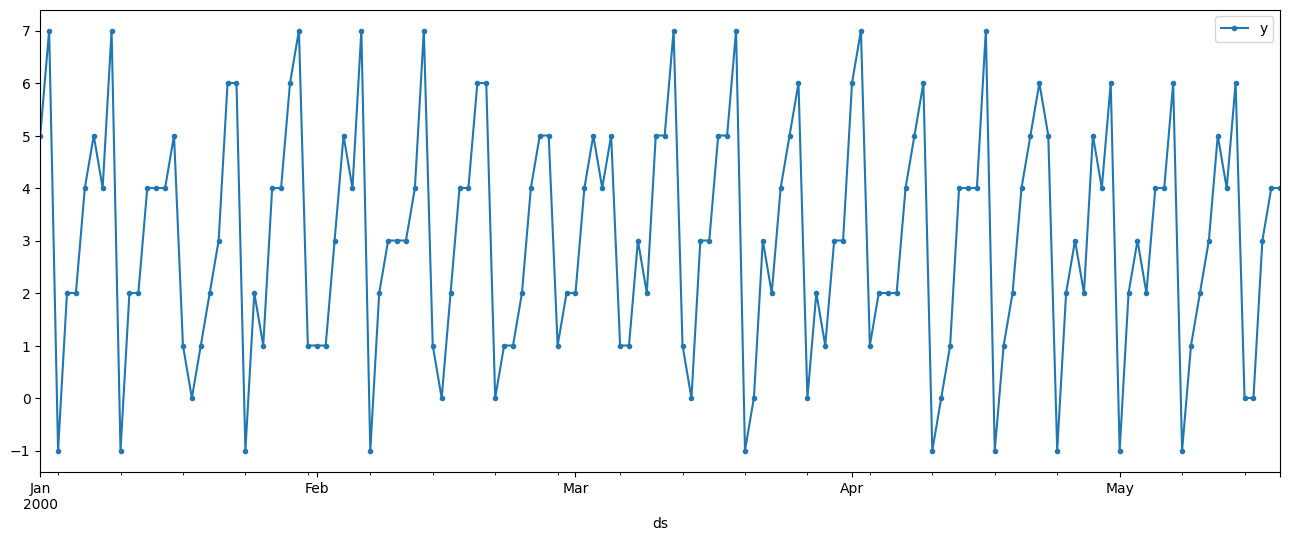

In [1]:
# EXAMPLE:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

# Data:
rng = np.random.RandomState(90)
serie_length = 7 * 20
dates = pd.date_range('2000-01-01', freq='D', periods=serie_length, name='ds')
y = dates.dayofweek + rng.randint(-1, 2, size=dates.size)
data = pd.DataFrame({'y': y.astype(np.float64)}, index=dates)
data.plot(marker='.', figsize=(16, 6))

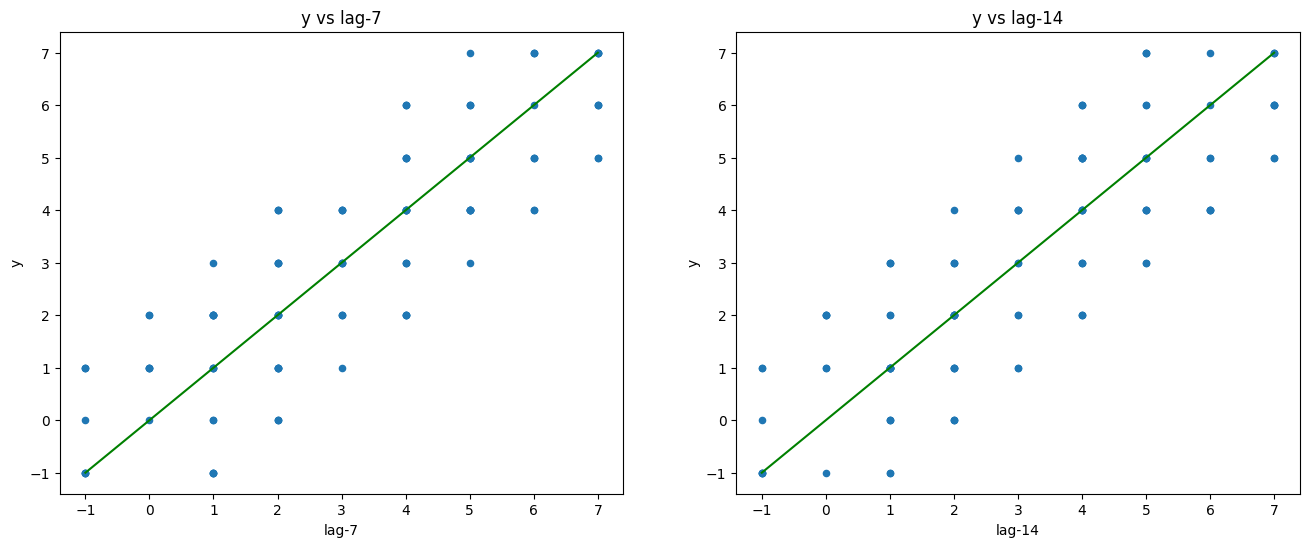

In [2]:
# TRAINING 

valid_horizon = 14
train = data.head(-valid_horizon).copy()
y_valid = data.tail(valid_horizon)['y']

## As a starting point, we’ll try lag 7 and lag 14.

train['lag-7'] = train['y'].shift(7)
train['lag-14'] = train['y'].shift(14)

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

for lag, axi in zip((7, 14), ax.flat):
    train.plot.scatter(x=f'lag-{lag}', y='y', ax=axi)
    axi.plot([-1, 7], [-1, 7], c='g')
    axi.set_title(f'y vs lag-{lag}')

In [3]:
train.isnull().sum()

y          0
lag-7      7
lag-14    14
dtype: int64

In [4]:
## We’ll drop these before training.

train_without_nulls = train.dropna()
X_train = train_without_nulls.drop(columns='y')
y_train = train_without_nulls['y']

In [5]:
# For simplicity sake, we’ll train a linear regression without intercept. 
# Since the best model would be taking the average for each day of the week, we expect to get coefficients that are close to 0.5.

lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
lr.coef_

array([0.5136953 , 0.44695162])

#### Forecasting

Great. We have our trained model. How can we compute the forecast for the next 14 days? Machine learning models a feature matrix X and output the predicted values y. So we need to create the feature matrix X for the next 14 days and give it to our model.

If we want to get the lag-7 for the next day, following the training set, we can just get the value in the 7th position starting from the end. The lag-7 two days after the end of the training set would be the value in the 6th position starting from the end and so on. Similarly for the lag-14.

In [6]:
next_lags_7 = y_train.tail(7).values
next_lags_7

array([ 4.,  6., -1.,  2.,  3.,  2.,  4.])

In [7]:
next_lags_14 = y_train.tail(14).values
next_lags_14

array([ 6.,  5., -1.,  2.,  3.,  2.,  5.,  4.,  6., -1.,  2.,  3.,  2.,
        4.])

In [8]:
X_valid1 = pd.DataFrame({
    'lag-7': next_lags_7,
    'lag-14': next_lags_14[:7],
})
X_valid1

,lag-7,lag-14
0,4.0,6.0
1,6.0,5.0
2,-1.0,-1.0
3,2.0,2.0
4,3.0,3.0
5,2.0,2.0
6,4.0,5.0


In [9]:
forecasts_7 = lr.predict(X_valid1)
forecasts_7

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928])

In [10]:
X_valid2 = pd.DataFrame({
    'lag-7': forecasts_7,
    'lag-14': next_lags_14[-7:],
})
X_valid2

,lag-7,lag-14
0,4.736491,4.0
1,5.316930,6.0
2,-0.960647,-1.0
3,1.921294,2.0
4,2.881941,3.0
5,1.921294,2.0
6,4.289539,4.0


In [11]:
forecasts_7_14 = lr.predict(X_valid2)
y_pred = np.hstack([forecasts_7, forecasts_7_14])
y_pred

array([ 4.7364909 ,  5.31692988, -0.96064692,  1.92129383,  2.88194075,
        1.92129383,  4.28953928,  4.22091958,  5.41299159, -0.94043142,
        1.88086285,  2.82129427,  1.88086285,  3.99132264])

What if we had used lag-1? We would have needed to do this predict-update step 14 times!

And what if we had more elaborate features like the rolling mean over some lag? As you can imagine it can get quite messy and is very error prone.

**mlforecast**

With these problems in mind, we created mlforecast, which is a framework to help you forecast time series using machine learning models. It takes care of all these messy details for you. You just need to give it a model and define which features you want to use and let mlforecast do the rest.

In [44]:
train_mlfcst = train.reset_index()[['ds', 'y']]
train_mlfcst.index = pd.Index(np.repeat(0, train.shape[0]), name='unique_id')
train_mlfcst.head()

,ds,y
unique_id,,
0,2000-01-01,5.0
0,2000-01-02,7.0
0,2000-01-03,-1.0
0,2000-01-04,2.0
0,2000-01-05,2.0


This is the required input format.

- an index named unique_id that identifies each time serie. In this case we only have one but you can have as many as you want.
- a ds column with the dates.
- a y column with the values.

Now we’ll import the **TimeSeries** transformer, where we define the features that we want to use. We’ll also import the **Forecast** class, which will hold our transformer and model and will run the forecasting pipeline for us.

In [42]:
# As you can see this transformer will use lag-7 and lag-14 as features. Now we define our model.

model = LinearRegression(fit_intercept=False)

In [45]:
# We create a Forecast object with the model and the time series transformer and fit it to our data.

from mlforecast import MLForecast

fcst = MLForecast(
    models=[model],
    freq='D',
    lags=[7, 14]
)

In [46]:
fcst.fit(train_mlfcst, id_col='index', time_col='ds', target_col='y')

MLForecast(models=[LinearRegression], freq=<Day>, lag_features=['lag-7', 'lag-14'], date_features=[], num_threads=1)

In [47]:
y_pred_mlfcst = fcst.predict(14)
y_pred_mlfcst

,ds,LinearRegression
unique_id,,
0,2000-05-06,4.736491
0,2000-05-07,5.316930
0,2000-05-08,-0.960647
0,2000-05-09,1.921294
0,2000-05-10,2.881941
0,2000-05-11,1.921294
0,2000-05-12,4.289539
0,2000-05-13,4.220920
0,2000-05-14,5.412992


## NeuralForecast